> Reference link: [basic use of linearRegression function in sklearn](https://hleecaster.com/ml-linear-regression-example/), [R-squared](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4678365/), [Regression analysis](http://www.sthda.com/english/articles/40-regression-analysis/164-interaction-effect-in-multiple-regression-essentials/)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("precision", 2) # number precision for pandas
# pd.set_option("display.max_rows", 10)
pd.set_option("display.float_format", "{:20,.2f}".format) # display float values to two decimal places
plt.style.use("seaborn") # pretty matplotlib plots

# To display print all the interactive output, not only the last result.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 1. Regression

## 1.1 Data Selection and Filtering

In [2]:
# load datasets

Laptop_df = pd.read_csv("../datasets/2022_March_LaptopData_India.csv")
Laptop_df.head(5)
# Laptop_df[Laptop_df['ram_gb']  == "NVIDIA"]

,brand,model,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,...,display_size,warranty,Touchscreen,msoffice,latest_price,old_price,discount,star_rating,ratings,reviews
0,ASUS,Celeron,Intel,Celeron Dual,Missing,4,DDR4,0,1024,Windows,...,15.6,1,No,No,23990,26990,11,3.80,15279,1947
1,ASUS,VivoBook,Intel,Core i3,10th,8,DDR4,512,0,Windows,...,15.6,1,No,No,37990,50990,25,4.30,990,108
2,ASUS,Vivobook,Intel,Core i3,10th,8,DDR4,0,1024,Windows,...,14.1,1,No,No,32890,46990,30,3.90,28,4
3,HP,Core,Intel,Core i3,11th,8,DDR4,512,0,Windows,...,15.6,1,No,Yes,42990,57330,25,4.40,158,18
4,HP,Core,Intel,Core i5,11th,8,DDR4,512,0,Windows,...,15.6,0,No,No,54990,70171,21,4.20,116,15


> [reference data link](https://www.kaggle.com/datasets/kuchhbhi/2022-march-laptop-data?select=Cleaned_Laptop_data.csv)
### Each column means
Dataset has a total of 23 columns. But I didn't write columns that could be understood easily.
* brand: Name of Manufacturer company
* model: Model of laptop
* processor_gnrtn: Generation of processor
* ram_gb: RAM installed in laptop
* ram_type: type of RAM
* weight: thinNight, casual, heavy(gaming)
* warranty: (measure: year)
* msoffice: pre-installed or not
* latest_price: (measure: INR), INR is the Indian Rupee, which is The Republic of India's official currency.
* old_price: Actual price in INR
* discount: (measure: %)
* star_rating: out of 5 star

In this analysis, I'll predict the old_price(Actual price), not a latest_price.

In [3]:
# Remove several columns 

Laptop_df = Laptop_df.drop(["processor_gnrtn", "ram_type", "os", "os_bit", "warranty", 
                            "latest_price", "discount"], axis = 1, inplace = False)
Laptop_df.head(100)

,brand,model,processor_brand,processor_name,ram_gb,ssd,hdd,graphic_card_gb,weight,display_size,Touchscreen,msoffice,old_price,star_rating,ratings,reviews
0,ASUS,Celeron,Intel,Celeron Dual,4,0,1024,0,Casual,15.6,No,No,26990,3.80,15279,1947
1,ASUS,VivoBook,Intel,Core i3,8,512,0,0,Casual,15.6,No,No,50990,4.30,990,108
2,ASUS,Vivobook,Intel,Core i3,8,0,1024,0,Casual,14.1,No,No,46990,3.90,28,4
3,HP,Core,Intel,Core i3,8,512,0,0,ThinNlight,15.6,No,Yes,57330,4.40,158,18
4,HP,Core,Intel,Core i5,8,512,0,0,ThinNlight,15.6,No,No,70171,4.20,116,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,APPLE,2020,Apple,M1 Processor,8,512,0,0,Casual,13.3,No,No,142900,4.60,399,45
96,ASUS,VivoBook,Intel,Core i3,8,256,0,0,Casual,15.6,No,No,58990,4.50,816,147
97,MSI,GF63,Intel,Core i5,8,512,0,4,Casual,15.6,No,No,83990,4.50,1597,228
98,MSI,Katana,Intel,i7,NaN,0,0,4,Casual,0,No,No,117990,4.50,218,27


In [4]:
# Exchange INR into dollars
# In 2022, April 22th, 1 INR = 0.013 dollars

# Exchange INR into dollars
Laptop_df["old_price"] = Laptop_df["old_price"] * 0.013

# Revise measure 1 dollar to 100 dollars because, 
# after doing Linear Regression, coefficient and intercept values are too high.
Laptop_df["old_price"] = Laptop_df["old_price"] / 100
Laptop_df["old_price"]

0                     3.51
1                     6.63
2                     6.11
3                     7.45
4                     9.12
              ...         
891                   7.68
892                   7.15
893                   0.00
894                   5.20
895                   5.72
Name: old_price, Length: 896, dtype: float64

In [5]:
# Rename columns 

Laptop_df = Laptop_df.rename(columns = {"ram_gb" : "RAM", "graphic_card_gb": "Graphic_card",
                                       "old_price" : "Price", "ssd" : "SSD", "hdd" : "HDD"}, 
                                         inplace = False)
Laptop_df.head(5)

,brand,model,processor_brand,processor_name,RAM,SSD,HDD,Graphic_card,weight,display_size,Touchscreen,msoffice,Price,star_rating,ratings,reviews
0,ASUS,Celeron,Intel,Celeron Dual,4,0,1024,0,Casual,15.6,No,No,3.51,3.80,15279,1947
1,ASUS,VivoBook,Intel,Core i3,8,512,0,0,Casual,15.6,No,No,6.63,4.30,990,108
2,ASUS,Vivobook,Intel,Core i3,8,0,1024,0,Casual,14.1,No,No,6.11,3.90,28,4
3,HP,Core,Intel,Core i3,8,512,0,0,ThinNlight,15.6,No,Yes,7.45,4.40,158,18
4,HP,Core,Intel,Core i5,8,512,0,0,ThinNlight,15.6,No,No,9.12,4.20,116,15


In [6]:
# Reorder columns: Response(Actual price) go to farthest to the right

Laptop_df.columns

Laptop_df = Laptop_df[['brand', 'model', 'processor_brand', 'processor_name', 'RAM', 'SSD',
       'HDD', 'Graphic_card', 'weight', 'display_size', 'Touchscreen',
       'msoffice', 'star_rating', 'ratings', 'reviews', 'Price' ]]

Laptop_df.head(3)

Index(['brand', 'model', 'processor_brand', 'processor_name', 'RAM', 'SSD',
       'HDD', 'Graphic_card', 'weight', 'display_size', 'Touchscreen',
       'msoffice', 'Price', 'star_rating', 'ratings', 'reviews'],
      dtype='object')

,brand,model,processor_brand,processor_name,RAM,SSD,HDD,Graphic_card,weight,display_size,Touchscreen,msoffice,star_rating,ratings,reviews,Price
0,ASUS,Celeron,Intel,Celeron Dual,4,0,1024,0,Casual,15.6,No,No,3.80,15279,1947,3.51
1,ASUS,VivoBook,Intel,Core i3,8,512,0,0,Casual,15.6,No,No,4.30,990,108,6.63
2,ASUS,Vivobook,Intel,Core i3,8,0,1024,0,Casual,14.1,No,No,3.90,28,4,6.11


In [7]:
# See the number of NaN data

Laptop_df.info()

Laptop_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brand            896 non-null    object 
 1   model            896 non-null    object 
 2   processor_brand  896 non-null    object 
 3   processor_name   895 non-null    object 
 4   RAM              871 non-null    object 
 5   SSD              896 non-null    int64  
 6   HDD              896 non-null    int64  
 7   Graphic_card     896 non-null    int64  
 8   weight           896 non-null    object 
 9   display_size     896 non-null    object 
 10  Touchscreen      896 non-null    object 
 11  msoffice         896 non-null    object 
 12  star_rating      896 non-null    float64
 13  ratings          896 non-null    int64  
 14  reviews          896 non-null    int64  
 15  Price            896 non-null    float64
dtypes: float64(2), int64(5), object(9)
memory usage: 112.1+ KB


brand               0
model               0
processor_brand     0
processor_name      1
RAM                25
SSD                 0
HDD                 0
Graphic_card        0
weight              0
display_size        0
Touchscreen         0
msoffice            0
star_rating         0
ratings             0
reviews             0
Price               0
dtype: int64

In [8]:
# Remove data that is misplaced 
misplaced_data = np.array([444, 543, 684, 693, 712, 720, 771, 822, 848, 884]) 
misplaced_data -= 2
Laptop_df = Laptop_df.drop(index = misplaced_data)


# Laptop_df = Laptop_df.drop(["Graphic_card"], axis = 1, inplace = False)
# Laptop_df = Laptop_df.replace(0, np.NaN)

# Remove NaN values
Laptop_df = Laptop_df.dropna(axis = 0, inplace = False)


# Change column data type
Laptop_df["RAM"] = Laptop_df["RAM"].astype(float)
Laptop_df["display_size"] = Laptop_df["display_size"].astype(float)

print("Laptop_df.describe() : \n")
Laptop_df.describe()

Laptop_df.describe() : 



,RAM,SSD,HDD,Graphic_card,display_size,star_rating,ratings,reviews,Price
count,861.00,861.00,861.00,861.00,861.00,861.00,861.00,861.00,861.00
mean,10.14,449.15,198.62,1.12,14.25,2.95,356.60,44.17,11.38
std,4.85,310.53,407.37,2.00,2.88,1.97,"1,103.71",133.88,7.08
min,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,8.00,256.00,0.00,0.00,14.00,0.00,0.00,0.00,7.15
50%,8.00,512.00,0.00,0.00,14.96,4.10,18.00,3.00,10.05
75%,16.00,512.00,0.00,2.00,15.60,4.40,165.00,21.00,14.22
max,32.00,"3,072.00","2,048.00",8.00,17.30,5.00,"15,279.00","1,947.00",49.11


## 1.2 Simple Linear Regression

In [9]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
# accuracy_score is used in classification

# Ordinary Least Squares(OLS) model with intercept
# What is OLS? a type of linear least squares method for estimating the unknown parameters in a linear regression model(Wikipedia)

OLS_sklearn = linear_model.LinearRegression(fit_intercept = True)

Real_Number_Predictors = ['RAM', 'SSD', 'HDD', 'Graphic_card',
                          'display_size', 'star_rating', 'ratings', 'reviews']

# fitted OLS model (.values.reshape(-1, 1) is required for single predictor) 
for i in Real_Number_Predictors:
    X_train = Laptop_df[i].values.reshape(-1, 1)
    y_true = Laptop_df["Price"]
    OLS_sklearn.fit(X_train, y_true)
    
    y_pred = OLS_sklearn.predict(Laptop_df[i].values.reshape(-1, 1))
    
    OLS_sklearn_summary = {"MSE": mean_squared_error(y_true, y_pred),
                          "Ex. Var": explained_variance_score(y_true, y_pred),
                          "R2": r2_score(y_true, y_pred)}
    
    print('Predictor is "%s"' % i)
    print(i, "intercept: ", OLS_sklearn.intercept_)
    print(i, "coefficient: ", OLS_sklearn.coef_)
    for k, v in OLS_sklearn_summary.items():
        print(k, ':', v)
    
    print() # make it easier to distinguish


LinearRegression()

Predictor is "RAM"
RAM intercept:  1.7042469826266036
RAM coefficient:  [0.95403049]
MSE : 28.645218601829793
Ex. Var : 0.42732840410457973
R2 : 0.42732840410457973



LinearRegression()

Predictor is "SSD"
SSD intercept:  5.8091024059221175
SSD coefficient:  [0.0123991]
MSE : 35.21304005730456
Ex. Var : 0.29602534628037935
R2 : 0.29602534628037946



LinearRegression()

Predictor is "HDD"
HDD intercept:  12.271932002909814
HDD coefficient:  [-0.0044999]
MSE : 46.66381922895907
Ex. Var : 0.06710281391546524
R2 : 0.06710281391546513



LinearRegression()

Predictor is "Graphic_card"
Graphic_card intercept:  9.475386080725809
Graphic_card coefficient:  [1.69948948]
MSE : 38.53208139471006
Ex. Var : 0.22967149065249937
R2 : 0.22967149065249925



LinearRegression()

Predictor is "display_size"
display_size intercept:  10.528384281793358
display_size coefficient:  [0.05964319]
MSE : 49.99094500350194
Ex. Var : 0.0005873352404116572
R2 : 0.0005873352404116572



LinearRegression()

Predictor is "star_rating"
star_rating intercept:  12.264650562863885
star_rating coefficient:  [-0.300031]
MSE : 49.66973476953888
Ex. Var : 0.007008929708181566
R2 : 0.007008929708181566



LinearRegression()

Predictor is "ratings"
ratings intercept:  11.70938259657741
ratings coefficient:  [-0.00092876]
MSE : 48.9707445544571
Ex. Var : 0.02098305389100752
R2 : 0.02098305389100752



LinearRegression()

Predictor is "reviews"
reviews intercept:  11.735964562687114
reviews coefficient:  [-0.00810019]
MSE : 48.84560890842131
Ex. Var : 0.02348474993720706
R2 : 0.02348474993720706



### Targets the top 3 predictors with high r2_score; RAM, ssd, Graphic_card

### 1. RAM

In [10]:
# using statsmodels
import statsmodels.api as sm

# predictor & depentent var
X_train = Laptop_df["RAM"]
y_true = Laptop_df["Price"]

# ols model with intercept added to predictor
OLS_sm = sm.OLS(y_true, sm.add_constant(X_train))

# fitted model and summary
OLS_sm_results = OLS_sm.fit()
OLS_sm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     641.0
Date:                Thu, 28 Apr 2022   Prob (F-statistic):          4.36e-106
Time:                        19:19:14   Log-Likelihood:                -2666.0
No. Observations:                 861   AIC:                             5336.
Df Residuals:                     859   BIC:                             5346.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7042      0.423      4.024      0.000       0.873       2.535
RAM            0.9540      0.038     25.318      0.000       0.880       1.028
==============================================================================
Omnibus:                      138.843   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1707.373
Skew:                           0.268   Prob(JB):                         0.00
Kurtosis:                       9.878   Cond. No.                         26.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='RAM', ylabel='Price'>

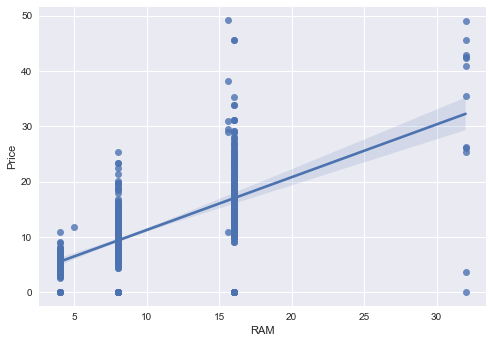

In [11]:
# Plot data and a linear regression model fit
sns.regplot(x = "RAM", y = "Price", data = Laptop_df)

### 2. ssd

In [12]:
# using statsmodels
import statsmodels.api as sm

# predictor & depentent var
X_train = Laptop_df["SSD"]
y_true = Laptop_df["Price"]

# ols model with intercept added to predictor
OLS_sm = sm.OLS(y_true, sm.add_constant(X_train))

# fitted model and summary
OLS_sm_results = OLS_sm.fit()
OLS_sm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     361.2
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           1.67e-67
Time:                        19:19:14   Log-Likelihood:                -2754.9
No. Observations:                 861   AIC:                             5514.
Df Residuals:                     859   BIC:                             5523.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8091      0.356     16.310      0.000       5.110       6.508
SSD            0.0124      0.001     19.006      0.000       0.011       0.014
==============================================================================
Omnibus:                      281.827   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5344.544
Skew:                           0.988   Prob(JB):                         0.00
Kurtosis:                      15.044   Cond. No.                         960.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='SSD', ylabel='Price'>

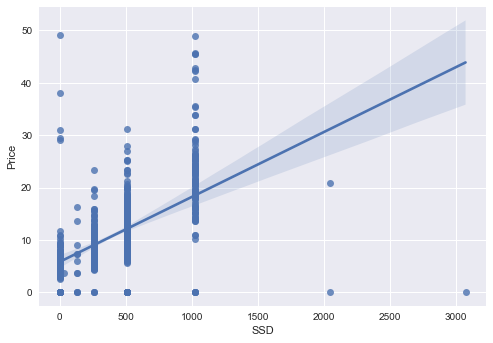

In [13]:
# Plot data and a linear regression model fit
sns.regplot(x = "SSD", y = "Price", data = Laptop_df)

### 3. Graphic_card

In [14]:
# using statsmodels
import statsmodels.api as sm

# predictor & depentent var
X_train = Laptop_df["Graphic_card"]
y_true = Laptop_df["Price"]

# ols model with intercept added to predictor
OLS_sm = sm.OLS(y_true, sm.add_constant(X_train))

# fitted model and summary
OLS_sm_results = OLS_sm.fit()
OLS_sm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     256.1
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           1.20e-50
Time:                        19:19:15   Log-Likelihood:                -2793.7
No. Observations:                 861   AIC:                             5591.
Df Residuals:                     859   BIC:                             5601.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            9.4754      0.243     39.012      0.000       8.999       9.952
Graphic_card     1.6995      0.106     16.003      0.000       1.491       1.908
==============================================================================
Omnibus:                      219.071   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              711.174
Skew:                           1.217   Prob(JB):                    3.72e-155
Kurtosis:                       6.728   Cond. No.                         2.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='Graphic_card', ylabel='Price'>

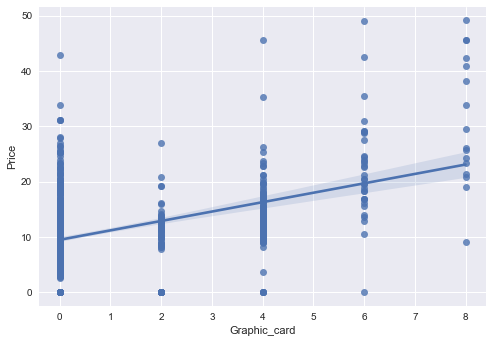

In [15]:
# Plot data and a linear regression model fit
sns.regplot(x = "Graphic_card", y = "Price", data = Laptop_df, order = 1)

Looking at the graph, the Simple Linear model is not suitable here. Also, The RAM's r2_score is less than 0.5, it is a low value. 

## 1.3 Multiple Linear Regression

Among predictors, I think the SSD and HDD are highly correlated because both are measures of memory, And Other features may also be correlated with each other. So I used a multiple linear regression model to see correlations of the several input. 

In [16]:
# SSD, HDD

import statsmodels.formula.api as smf

# OLS model with intercept
OLS_smf = smf.ols(formula = "Price ~ SSD * HDD", data = Laptop_df)

OLS_smf_results = OLS_smf.fit()
OLS_smf_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     121.4
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           1.53e-65
Time:                        19:19:16   Log-Likelihood:                -2753.5
No. Observations:                 861   AIC:                             5515.
Df Residuals:                     857   BIC:                             5534.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.7256      0.466     12.279      0.000       4.810       6.641
SSD            0.0124      0.001     16.005      0.000       0.011       0.014
HDD           -0.0003      0.001     -0.366      0.714      -0.002       0.001
SSD:HDD     4.953e-06   3.32e-06      1.490      0.137   -1.57e-06    1.15e-05
==============================================================================
Omnibus:                      286.207   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5497.202
Skew:                           1.008   Prob(JB):                         0.00
Kurtosis:                      15.213   Cond. No.                     1.92e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.92e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* According to the table, p-values of both SSD and interaction between SSD and HDD are significant. That is, when they are considered separately, it seems that each of them positively affects Price.
* The p-value of the HDD is too high, so HDD isn't necessarily. But, because of the **hierarchy principle**, we should also include the HHD.
* The R-squared value is too low, so the datas doesn't fit well in the regression model.

<br>

cf> hierarchy principle: If we include an interaction in a model, we should also include the main effects, even if the p-values associated with their coefficients are not significant.

In [17]:
# RAM, SSD

import statsmodels.formula.api as smf

# OLS model with intercept
OLS_smf = smf.ols(formula = "Price ~ RAM * SSD", data = Laptop_df)

OLS_smf_results = OLS_smf.fit()
OLS_smf_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     258.5
Date:                Thu, 28 Apr 2022   Prob (F-statistic):          1.97e-119
Time:                        19:19:16   Log-Likelihood:                -2628.6
No. Observations:                 861   AIC:                             5265.
Df Residuals:                     857   BIC:                             5284.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4062      0.607     -0.669      0.504      -1.597       0.785
RAM            0.9095      0.062     14.768      0.000       0.789       1.030
SSD            0.0092      0.001      7.833      0.000       0.007       0.012
RAM:SSD       -0.0003   7.44e-05     -3.891      0.000      -0.000      -0.000
==============================================================================
Omnibus:                      167.692   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2631.709
Skew:                           0.383   Prob(JB):                         0.00
Kurtosis:                      11.531   Cond. No.                     2.94e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.94e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

According to the table, the p-values of three features are significant. That is, when they are considered separately, it seems that each of them positively affects Price.
The R-squared value is approximately 0.5, so approximately 50% of the variability in the outcome data cannot be explained by the model. 

In [18]:
# RAM, SSD, Graphic_card

import statsmodels.formula.api as smf

# OLS model with intercept
OLS_smf = smf.ols(formula = "Price ~ RAM * SSD * Graphic_card", data = Laptop_df)

OLS_smf_results = OLS_smf.fit()
OLS_smf_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     147.7
Date:                Thu, 28 Apr 2022   Prob (F-statistic):          2.28e-142
Time:                        19:19:16   Log-Likelihood:                -2564.2
No. Observations:                 861   AIC:                             5144.
Df Residuals:                     853   BIC:                             5183.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.9294      0.791      4.966      0.000       2.376       5.482
RAM                      0.2487      0.093      2.670      0.008       0.066       0.432
SSD                      0.0045      0.002      2.626      0.009       0.001       0.008
RAM:SSD                  0.0004      0.000      2.694      0.007       0.000       0.001
Graphic_card            -0.9195      0.361     -2.545      0.011      -1.629      -0.210
RAM:Graphic_card         0.1947      0.027      7.329      0.000       0.143       0.247
SSD:Graphic_card         0.0010      0.001      2.022      0.043    3.06e-05       0.002
RAM:SSD:Graphic_card    -0.0002   3.23e-05     -5.439      0.000      -0.000      -0.000
==============================================================================
Omnibus:                      151.362   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2188.344
Skew:                          -0.290   Prob(JB):                         0.00
Kurtosis:                      10.789   Cond. No.                     1.95e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.95e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

According to the table, the p-values of the all features are significant. That is, when they are considered separately, it seems that each of them positively affects Price.
The R-squared value is more than 0.5, so approximately 55% of the variability in the outcome data can be explained by the model. 